In [82]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as optim
from scipy.integrate import odeint, solve_ivp

In [161]:
m_p0p1 = 0.0265
m_p4950 = 0.0057

m_p0G = 0.0022
m_p49G = 0.0031

m_p0S = 0.0052
m_p49S = 0.0011

m_p0A = 0.0018
m_p49A = 0.0016

m_GS = 6.837 * 10**(-4)
m_AD = 0.0011

    k = 100

In [84]:
N = 50

In [122]:
def interpolate(left, right, plot=False):
    x = np.arange(2, N)
    xp = [1, 50]
    fp = [left, right]
    y = np.interp(x, xp, fp)
    y = list(y)
    y.append(right)
    y.insert(0, left)
    if plot:
        plt.plot(np.arange(1,N+1), y)
        plt.show()
    return y

In [86]:
m_pipinext = interpolate(m_p0p1, m_p4950)
m_piG = interpolate(m_p0G, m_p49G)
m_piS = interpolate(m_p0S, m_p49S)
m_piA = interpolate(m_p0A, m_p49A)
prob = interpolate(0, 1/25)

In [169]:
def f_original(t, v, m_pipinext, m_piG, m_piS, m_piA, m_GS, m_AD):
    all_prolifs = []
    S = v[50]
    G = v[51]
    A = v[52]
    for i in range(N):
        all_prolifs.append(v[i])

    prolif_1_to_49_f = []
    f0 = -(m_pipinext[0] + m_piS[0] + m_piA[0] + m_piG[0]) * all_prolifs[0]
    for i in range(1, N):
        prolif_1_to_49_f.append(2 * m_pipinext[i] * all_prolifs[i-1] -
                                (m_pipinext[i] + m_piS[i] + m_piA[i] + m_piG[i]) * all_prolifs[i])

    fS = 2 * m_pipinext[-1] * all_prolifs[-1] + m_GS * G
    for i in range(N):
        fS += m_piS[i] * all_prolifs[i]

    fG = -m_GS * G
    for i in range(N):
        fG += m_piG[i] * all_prolifs[i]

    fA = -m_AD * A
    for i in range(N):
        fA += m_piA[i] * all_prolifs[i]

    return [f0, *prolif_1_to_49_f, fS, fG, fA]

In [164]:
def f(t, v, m_pipinext, m_piG, m_piS, m_piA, m_GS, m_AD, k):
    all_prolifs = []
    S = v[50]
    G = v[51]
    A = v[52]
    for i in range(N):
        all_prolifs.append(v[i])

    prolif_1_to_49_f = []
    f0 = -(m_pipinext[0] + m_piS[0] + m_piA[0] + m_piG[0]) * all_prolifs[0] + prob[0] * k * G
    for i in range(1, N):
        prolif_1_to_49_f.append(2 * m_pipinext[i] * all_prolifs[i-1] -
                                (m_pipinext[i] + m_piS[i] + m_piA[i] + m_piG[i]) * all_prolifs[i] + prob[i] * k * G)

    fS = 2 * m_pipinext[-1] * all_prolifs[-1] + m_GS * G
    for i in range(N):
        fS += m_piS[i] * all_prolifs[i]

    fG = -m_GS * G - k * G
    for i in range(N):
        fG += m_piG[i] * all_prolifs[i]

    fA = -m_AD * A
    for i in range(N):
        fA += m_piA[i] * all_prolifs[i]

    return [f0, *prolif_1_to_49_f, fS, fG, fA]

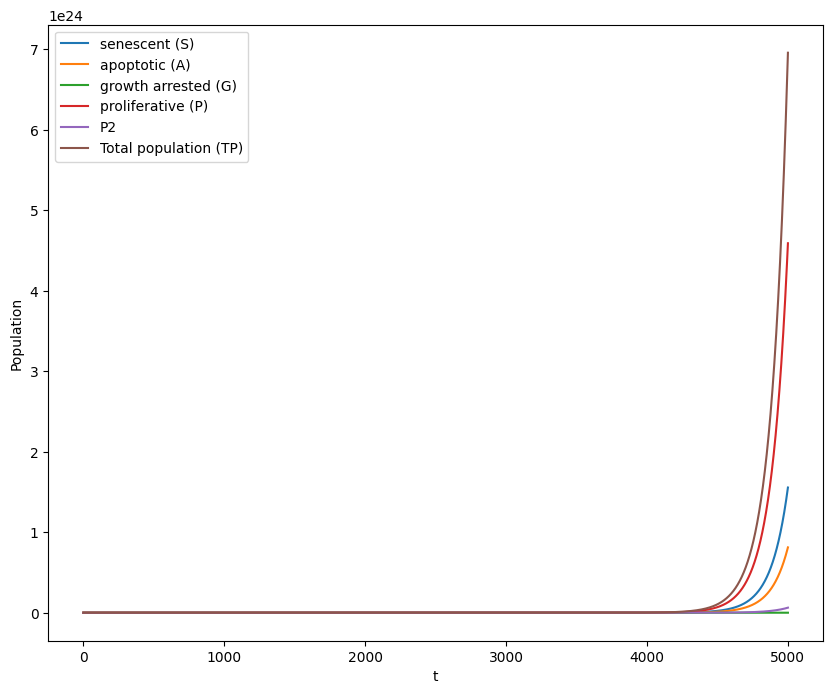

In [176]:
ic = [150000]
ic = ic + [0] * (N + 2)

t  = np.linspace(0, 5000, 10000) 
soln = odeint(f, ic, t, tfirst=True, args=(m_pipinext, m_piG, m_piS, m_piA, m_GS, m_AD, k))

all_prolifs = []

for i in range(N):
    all_prolifs.append(soln[:, i])

S = soln[:, N]
G = soln[:, N + 1]
A = soln[:, N + 2]
P = np.sum(np.array(all_prolifs), axis=0)
TP = S + G + A + P
plt.figure(figsize=(10, 8))
plt.plot(t, S, label='senescent (S)')
plt.plot(t, A, label='apoptotic (A)')
plt.plot(t, G, label='growth arrested (G)')
plt.plot(t, P, label='proliferative (P)')
plt.plot(t, all_prolifs[49], label='P2')
plt.plot(t, TP, label='Total population (TP)')

# plt.plot(t, v, label='v')
plt.xlabel('t')
plt.ylabel('Population')
plt.legend()
plt.show()
# plt.savefig(f'3c_{alpha}', bbox_inches='tight')

In [177]:
G

array([0.00000000e+00, 3.33186171e+00, 3.36476486e+00, ...,
       1.25209866e+20, 1.25735971e+20, 1.26264286e+20])

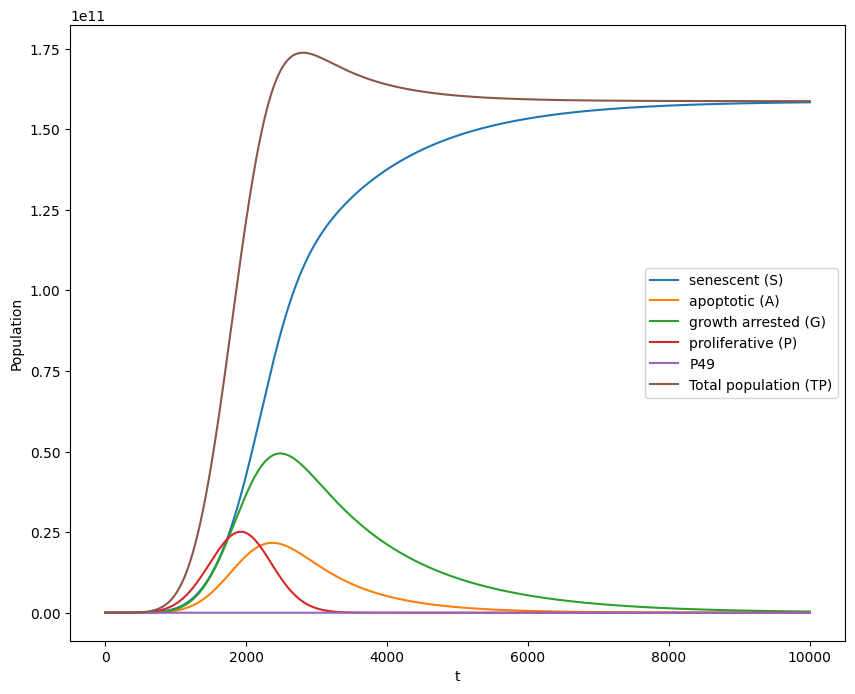

In [175]:
ic = [150000]
ic = ic + [0] * (N + 2)

t  = np.linspace(0, 10000, 10000) 
soln = odeint(f_original, ic, t, tfirst=True, args=(m_pipinext, m_piG, m_piS, m_piA, m_GS, m_AD,))

all_prolifs = []

for i in range(N):
    all_prolifs.append(soln[:, i])

S = soln[:, N]
G = soln[:, N + 1]
A = soln[:, N + 2]
P = np.sum(np.array(all_prolifs), axis=0)
TP = S + G + A + P
plt.figure(figsize=(10, 8))
plt.plot(t, S, label='senescent (S)')
plt.plot(t, A, label='apoptotic (A)')
plt.plot(t, G, label='growth arrested (G)')
plt.plot(t, P, label='proliferative (P)')
plt.plot(t, all_prolifs[4], label='P49')
plt.plot(t, TP, label='Total population (TP)')

# plt.plot(t, v, label='v')
plt.xlabel('t')
plt.ylabel('Population')
plt.legend()
plt.show()
# plt.savefig(f'3c_{alpha}', bbox_inches='tight')